In [33]:
import pandas as pd
import dalecLoad
import numpy as np
import statistics
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import time
from scipy import interpolate

In [2]:
logList = []
for i in range(8):
    filepath = 'data/Jul-Aug/LOG_00' + str(82 + i) + '.dtf'
    print('loading ... ' + str(filepath))
    logList.append(dalecLoad.load_DALEC_log(filepath))
logList

loading ... data/Jul-Aug/LOG_0082.dtf
loading ... data/Jul-Aug/LOG_0083.dtf
loading ... data/Jul-Aug/LOG_0084.dtf
loading ... data/Jul-Aug/LOG_0085.dtf
loading ... data/Jul-Aug/LOG_0086.dtf
loading ... data/Jul-Aug/LOG_0087.dtf
loading ... data/Jul-Aug/LOG_0088.dtf
loading ... data/Jul-Aug/LOG_0089.dtf


[                   spectral_ind  Pitch  Voltage  GPS_Fix   UTC Date  \
 Sample #  Channel                                                     
 28905    Ed                  21    0.0     11.6        A 2022-08-08   
          Ed                  22    0.0     11.6        A 2022-08-08   
          Ed                  23    0.0     11.6        A 2022-08-08   
          Ed                  24    0.0     11.6        A 2022-08-08   
          Ed                  25    0.0     11.6        A 2022-08-08   
 ...                         ...    ...      ...      ...        ...   
 36178    Lu                 216    0.0     11.6        A 2022-08-08   
          Lu                 217    0.0     11.6        A 2022-08-08   
          Lu                 218    0.0     11.6        A 2022-08-08   
          Lu                 219    0.0     11.6        A 2022-08-08   
          Lu                 220    0.0     11.6        A 2022-08-08   
 
                        UTC Time         Lat  Heading  Relaz  

In [3]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(filepath)

In [ ]:
# WARNING THIS MAKES NICE GRAPHS BUT WILL TAKE ABOUT 25 MINS TO RUN

fig, ax = plt.subplots(4, 2, figsize=(10, 10))

ax = ax.flatten()

for i in range(len(logList)):
    for sample in logList[i].index.get_level_values('Sample #').unique():
            spectra = dalecLoad.uniform_grid_spectra_Rrs(logList[i].loc[sample],
                                           spect_wavelengths)
            ax[i].plot(spectra['Wavelength'], (spectra['Rrs']))

In [4]:
for i in range(len(logList)):
    print(len(logList[i].index.get_level_values('Sample #').unique()))

7272
7423
7536
7482
7621
7622
7688
7022


In [ ]:
# WARNING THIS MAKES NICE GRAPHS BUT WILL TAKE ABOUT 25 MINS TO RUN
fig, ax = plt.subplots(2, 4, figsize=(10, 10))

ax = ax.flatten()


for i in range(len(logList)):
    segs = []
    print('log ' + str(i))
    for sample in logList[i].index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(logList[i].loc[sample],
                                       spect_wavelengths)
        wavelengths = spectra['Wavelength'].values
        Rrs = spectra['Rrs'].values
        spect_arr = np.stack((wavelengths, Rrs), 1)
        segs.append(spect_arr)
    print('adding collection!') 
    line_segments = LineCollection(segs, alpha=0.1)      
    ax[i].add_collection(line_segments)
    ax[i].autoscale()
    
plt.show()

In [ ]:
# I made this to see if I could speed up some stuff with the plotting
# alas I discovered the real time killer is the interpolation step :(
def loadSpectArray(sample, dalecLog, spect_wavelengths):
    """
    Takes in a DALEC log file which has been loaded into memory using dalecLoad.load_DALEC_log()
    and a sample number (can be obtained with dalecLog.index.get_level_values('Sample #').unique())
    and outputs a 2 column array with wavelengths and Rrs  columns
    this can be used for plotting eg. with a LineCollection
    """
    spectra = dalecLoad.uniform_grid_spectra_Rrs(dalecLog.loc[sample],
                                                 spect_wavelengths)
    wavelengths = spectra['Wavelength'].values
    Rrs = spectra['Rrs'].values
    spect_arr = np.stack((wavelengths, Rrs), 1)

## Progression of August Bloom on Airthrey Loch

if we follow the progress of the bloom over 8 days (using mean spectra for each day, sampling at approx 5Hz from 11:00- 15:00 BST), we see the prominence of several key absorption features changing over time.

Firstly, the phycocyanin feature (absorption peak, which shows as reflectance trough) at approx 620 nm appears to become progressively more prominent over time, particularly in the last four days. This suggests a cyanobacterial bloom.

Alongside this, there is strong evidence of chl-a development during this time period, which can be seen at 450 and 680 nm.

This bloom coincided with a long drought period, which produced extremely low water levels. The result of this was that sonic units designed to prevent the formation of algal blooms were periodically sitting above the water level and therefore unable to work as intended. This may be a factor which contributed to the bloom.  

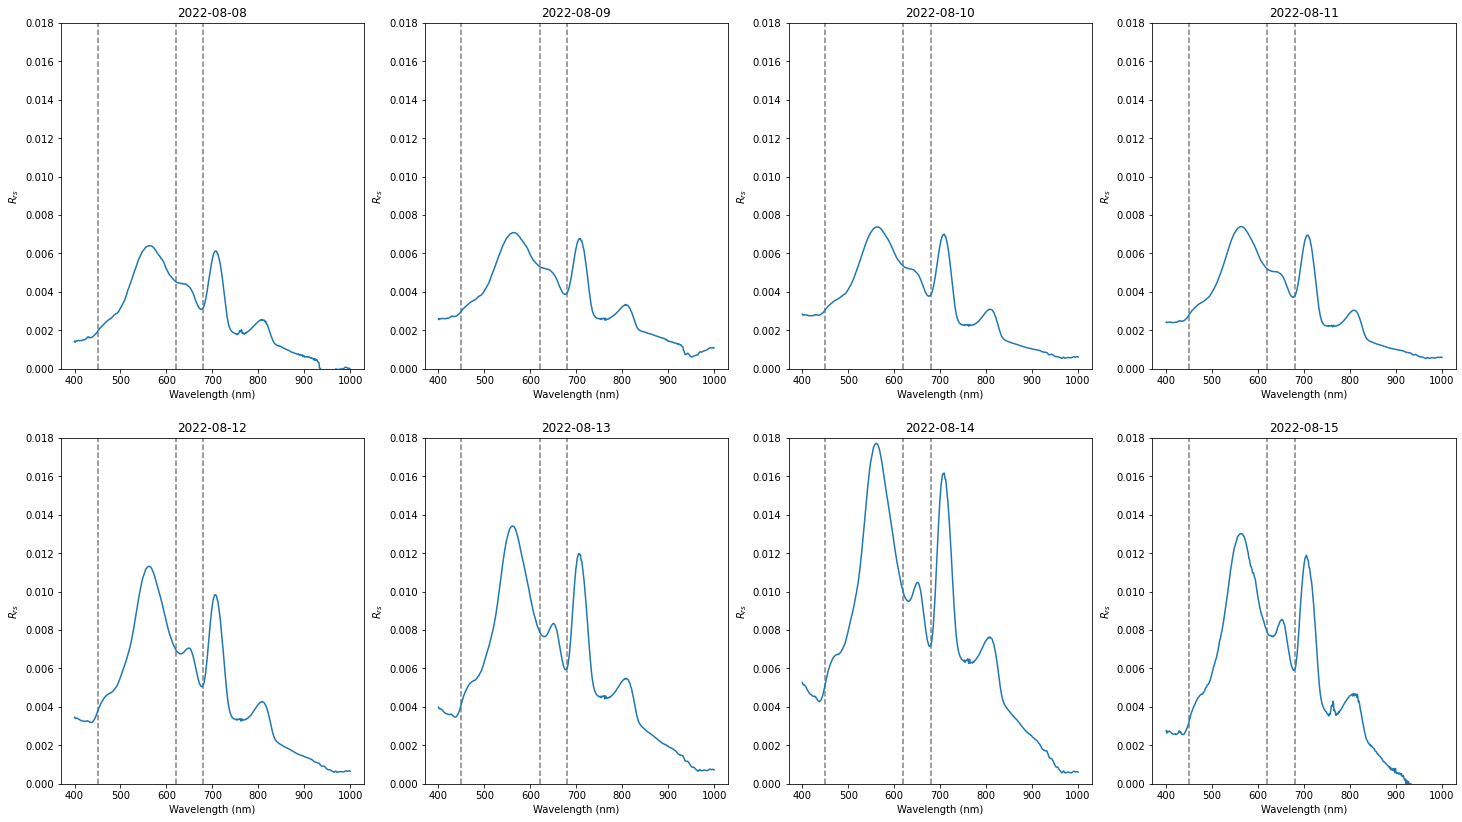

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(25, 14))

ax = ax.flatten()
RHO = 0.028

for i in range(len(logList)):
    mean_spect = dalecLoad.uniform_grid_spectra_mean(logList[i], spect_wavelengths)
    
    # plot 620 nm line (P-C absorption feature) 
    ax[i].plot([620, 620], [0, 1.0], 'k--', alpha=0.5)
    ax[i].plot([680, 680], [0, 1.0], 'k--', alpha=0.5)
    ax[i].plot([450, 450], [0, 1.0], 'k--', alpha=0.5)

    
    ax[i].plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
    ax[i].set_title(str(logList[i][' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
    ax[i].set_ylim(0, 0.018)
    ax[i].set_ylabel('$R_{rs}$')
    ax[i].set_xlabel('Wavelength (nm)')
    
    

        

plt.show()

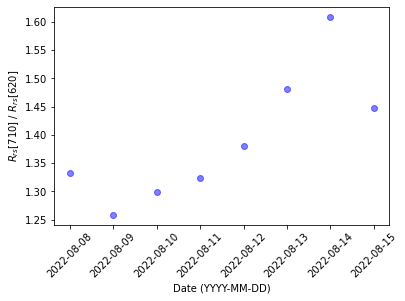

In [5]:
# looking at ratio of 620 to 710 band, as this is good for P-C detection (see Hunter, 2010)

PC_ratio = []
dates = []

for i in range(len(logList)):
    mean_spect = dalecLoad.uniform_grid_spectra_mean(logList[i], spect_wavelengths)
    y_710 = mean_spect.loc[mean_spect['Wavelength'] == 710]['Rrs_mean'].values
    y_620 = mean_spect.loc[mean_spect['Wavelength'] == 620]['Rrs_mean'].values
    PC_ratio.append(y_710/y_620)
    dates.append(str(logList[i][' UTC Date'].iloc[0])[:10])

plt.scatter(dates,PC_ratio, color='b', alpha=0.5)
plt.xticks(rotation = 45)
plt.xlabel('Date (YYYY-MM-DD)')
plt.ylabel('$R_{rs}[710]$ / $R_{rs}[620]$')
plt.show()

In [6]:
# this has now been added to the dalecLoad file :)
def uniform_grid_spectra_mean(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000):
    """
    - takes mean spectrum from an entire DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - returns a pandas DF with Lu_mean, Lsky_mean and Ed_mean
    """

    
    # better way like this, which takes mean then does spectra regridding stuff
    #  currently not working! need to work on this some more haha
    df = DALEC_log.copy() # not sure if neccesary but perhaps best to be on the safe side?
    df.set_index('spectral_ind', append=True, inplace=True)
    df = df.groupby(level=[' Channel', 'spectral_ind']).mean(numeric_only=True)
    Lu_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
    Lsky_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
    Ed_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
    
    Rrs_mean = (Lu_mean[:, 1] - (RHO * Lsky_mean[:, 1])) / Ed_mean[:, 1]
    
    # might be nice to output Rrs too?
    df_out = pd.DataFrame(data={'Wavelength': Lu_mean[:, 0],
                               'Lu_mean': Lu_mean[:, 1], 
                               'Lsky_mean': Lsky_mean[:, 1],
                               'Ed_mean': Ed_mean[:, 1],
                               'Rrs_mean': Rrs_mean})
    return df_out

In [165]:
def uniform_grid_spectra(DALEC_sample, spect_wavelengths, param='Lu', nsteps=200, min_waveL=400, max_waveL=1000):
    """
    - takes spectrum from a single sample of a DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - param gives which variable to grid: can choose between 'Lu', 'Lsky' and 'Ed' 
    """
    wavelength_grid = np.linspace(min_waveL, max_waveL, num=nsteps)
    
    y = DALEC_sample.loc[param]['Spectral Magnitude'].values
    x = spect_wavelengths[param].values

    interp = interpolate.interp1d(x, y, axis=0)
    out = np.column_stack((wavelength_grid,
                         interp(wavelength_grid)))
    
    return out

def uniform_grid_spectra_stats(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000, 
                               percentiles=[.25, .5, .75],
                               fastGridding=True):
    """
    - finds summary stats from an entire DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - returns a pandas DF with Lu_mean, Lsky_mean and Ed_mean
    """
    df = DALEC_log.copy() # not sure if neccesary but perhaps best to be on the safe side?
    
    # drop saturation flag to prevent this being included in the summary
    df.drop(labels=' Saturation Flag', axis=1, inplace=True)
    df.set_index('spectral_ind', append=True, inplace=True)
    
    if fastGridding:
        print('WARNING: fastGridding enabled! - this will produce results much faster,'
              + ' but works by calculating Rrs before Lu, Lsky, and Ed have been interpolated'
              + ' to the same wavelength grid. Therefore, Rrs calculation may be inaccurate.')
        
        Lu = df.loc[:, 'Lu', :]['Spectral Magnitude'].droplevel(' Channel')
        Lsky = df.loc[:, 'Lsky', :]['Spectral Magnitude'].droplevel(' Channel')
        Ed = df.loc[:, 'Ed', :]['Spectral Magnitude'].droplevel(' Channel')
    
        df_Rrs = (Lu - (RHO * Lsky)) / Ed
        df_Rrs = df_Rrs.groupby(level=['spectral_ind']).describe(percentiles=percentiles)
        wavelength_grid = np.linspace(min_waveL, max_waveL, num=nsteps)
    
        y = df_Rrs.values
        x = spect_wavelengths['Lu'].values

        interp = interpolate.interp1d(x, y, axis=0)
        Rrs_summary = np.column_stack((wavelength_grid,
                                   interp(wavelength_grid)))
        colnames = ['wavelength'] + list(df_Rrs.columns) # get column names
        df_out = pd.DataFrame(data=Rrs_summary, columns=colnames)

    else:
        print('WARNING fast gridding disabled. Interpolation of Lu, Lsky and Ed may be VERY SLOW \
               for datasets with large numbers of samples. Try enabling fastGridding for much faster,\
               but potentially less accurate results... \n \n \
               NOTE: "slowGridding" not yet developed. \n \n \
               RETURNING None')

        df_out = None
    
    #df = df.groupby(level=[' Channel', 'spectral_ind']).describe(percentiles=percentiles)
    

    #Lu_summary = uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
    # this should have shape (nsteps, 9), where columns are:
    # wavelength, count, mean, std, min, 25%, 50%, 75%, max
    # note that cols will be different if length of percentiles arg changes
    #Lsky_summary = uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
    #Ed_summary = uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
    
    # performing this calculation with the mean makes sense, but I'm not sure it actually makes sense
    # for the SD, median etc... NEED TO FIX THIS
    
    # options: calc Rrs before regridding and calc'ing percentiles etc. (will be fast)
    # regrid entire dataset and calc Rrs for everything, then do summary of this directly (will be SLOWWWW)
    
    #Rrs_summary = (Lu_summary[:, 1:] - (RHO * Lsky_summary[:, 1:])) / Ed_summary[:, 1:]
    #Rrs_summary = uniform_grid_spectra(df_Rrs, spect_wavelengths, param='Rrs', nsteps=nsteps)
    
    #colnames = ['wavelength'] + [x[1] for x in list(df.columns)] # get column names
    #data = np.concatenate([Lu_summary[:, 0].reshape(nsteps, 1), Rrs_summary], axis=1)
#    df_out = pd.DataFrame(data=data, columns=colnames)
    #df_out = pd.DataFrame(data=Rrs_summary, columns=colnames)
    return df_out


def uniform_grid_spectra_mean(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000):
    """
    - takes mean spectrum from an entire DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - returns a pandas DF with Lu_mean, Lsky_mean and Ed_mean
    """
    # this is a much more optimal way than previously! - 
    df = DALEC_log.copy() # not sure if neccesary but perhaps best to be on the safe side?
    # setting spectral_ind as an index might be useful for other stuff too?
    df.set_index('spectral_ind', append=True, inplace=True)
    df = df.groupby(level=[' Channel', 'spectral_ind']).mean(numeric_only=True)
    Lu_mean = uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
    Lsky_mean = uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
    Ed_mean = uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
    
    Rrs_mean = (Lu_mean[:, 1] - (RHO * Lsky_mean[:, 1])) / Ed_mean[:, 1]
    
    df_out = pd.DataFrame(data={'Wavelength': Lu_mean[:, 0],
                               'Lu_mean': Lu_mean[:, 1], 
                               'Lsky_mean': Lsky_mean[:, 1],
                               'Ed_mean': Ed_mean[:, 1],
                               'Rrs_mean': Rrs_mean})
    return df_out

In [166]:
df_summary = uniform_grid_spectra_stats(logList[5], spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])

In [167]:
df_summary

,wavelength,count,mean,std,min,5%,25%,50%,75%,95%,max
0,400.0,7622.0,0.004017,0.000658,0.002669,0.003121,0.003552,0.003894,0.004372,0.005443,0.005967
1,401.0,7622.0,0.003995,0.000648,0.002679,0.003117,0.003534,0.003872,0.004348,0.005397,0.005920
2,402.0,7622.0,0.003976,0.000638,0.002695,0.003116,0.003517,0.003853,0.004326,0.005352,0.005877
3,403.0,7622.0,0.003957,0.000628,0.002711,0.003115,0.003501,0.003833,0.004305,0.005308,0.005834
4,404.0,7622.0,0.003938,0.000620,0.002715,0.003108,0.003484,0.003814,0.004286,0.005269,0.005795
...,...,...,...,...,...,...,...,...,...,...,...
596,996.0,7622.0,0.000764,0.000564,-0.002083,-0.000088,0.000469,0.000754,0.001044,0.001605,0.004422
597,997.0,7622.0,0.000784,0.000569,-0.002066,-0.000063,0.000484,0.000771,0.001065,0.001635,0.004566
598,998.0,7622.0,0.000790,0.000577,-0.002126,-0.000064,0.000484,0.000778,0.001075,0.001650,0.004624
599,999.0,7622.0,0.000772,0.000588,-0.002312,-0.000106,0.000461,0.000766,0.001065,0.001640,0.004542


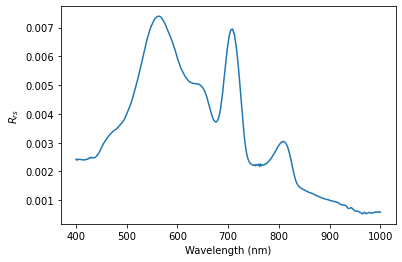

In [172]:
# just to check that my modification to uniform grid spectra doesn't break things:
mean_spect = uniform_grid_spectra_mean(logList[3], spect_wavelengths)

fig, ax = plt.subplots()

ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
ax.set_ylabel('$R_{rs}$')
ax.set_xlabel('Wavelength (nm)')
    
plt.show()

In [108]:
mean_spect

,Wavelength,Lu_mean,Lsky_mean,Ed_mean,Rrs_mean
0,400.0,0.002993,0.045250,0.711170,0.002427
1,401.0,0.003075,0.046649,0.737297,0.002398
2,402.0,0.003152,0.047284,0.763425,0.002395
3,403.0,0.003230,0.047918,0.782885,0.002412
4,404.0,0.003278,0.048552,0.793509,0.002418
...,...,...,...,...,...
596,996.0,0.000284,0.001548,0.406888,0.000592
597,997.0,0.000286,0.001527,0.404736,0.000602
598,998.0,0.000286,0.001507,0.402583,0.000606
599,999.0,0.000282,0.001557,0.400104,0.000595


In [90]:
df_summary = uniform_grid_spectra_stats(logList[5], spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])

MultiIndex([('Spectral Magnitude', 'count'),
            ('Spectral Magnitude',  'mean'),
            ('Spectral Magnitude',   'std'),
            ('Spectral Magnitude',   'min'),
            ('Spectral Magnitude',    '5%'),
            ('Spectral Magnitude',   '25%'),
            ('Spectral Magnitude',   '50%'),
            ('Spectral Magnitude',   '75%'),
            ('Spectral Magnitude',   '95%'),
            ('Spectral Magnitude',   'max')],
           )
(601,)
(601, 10)
(601, 11)


In [91]:
df_summary

,wavelength,count,mean,std,min,5%,25%,50%,75%,95%,max
0,400.0,0.972,0.003985,0.000449,0.005877,0.005891,0.004034,0.003887,0.003870,0.003277,0.002942
1,401.0,0.972,0.003924,0.000383,0.005778,0.005819,0.003977,0.003831,0.003811,0.003201,0.002861
2,402.0,0.972,0.003906,0.000364,0.005743,0.005804,0.003961,0.003815,0.003793,0.003179,0.002837
3,403.0,0.972,0.003923,0.000349,0.005761,0.005840,0.003980,0.003832,0.003808,0.003186,0.002839
4,404.0,0.972,0.003916,0.000301,0.005753,0.005847,0.003979,0.003828,0.003804,0.003160,0.002810
...,...,...,...,...,...,...,...,...,...,...,...
596,996.0,0.972,0.000741,-0.000686,-0.001817,0.001000,0.000838,0.000859,0.000779,0.000095,0.000504
597,997.0,0.972,0.000750,-0.000685,-0.000795,0.000998,0.000850,0.000871,0.000789,0.000093,0.000427
598,998.0,0.972,0.000753,-0.000688,-0.000482,0.000990,0.000853,0.000877,0.000797,0.000084,0.000372
599,999.0,0.972,0.000740,-0.000684,-0.001447,0.000957,0.000834,0.000869,0.000794,0.000071,0.000386


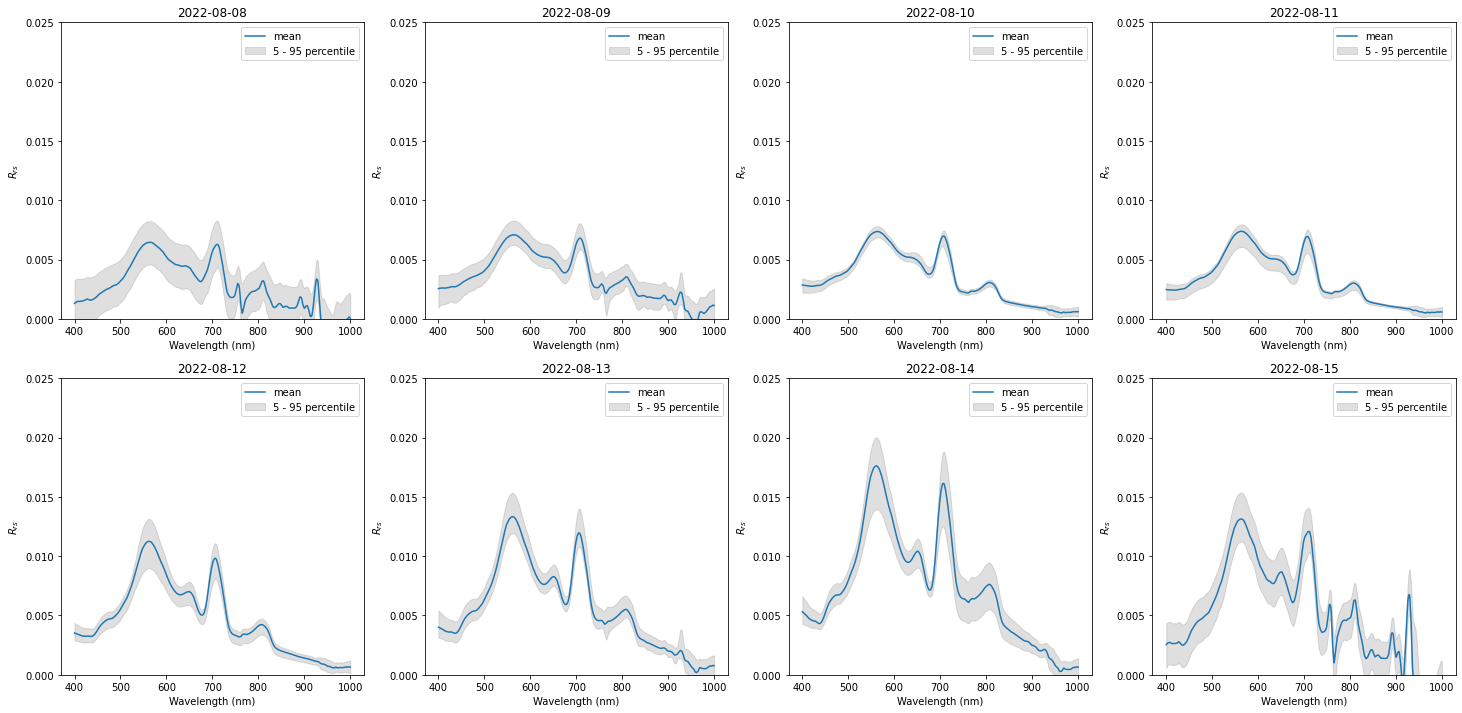

In [178]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i in range(len(logList)):

    df_summary = uniform_grid_spectra_stats(logList[i], spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])
    
#     y_95_1 = df_summary['mean'] + (1.96 * df_summary['std'])
#     y_95_2 = df_summary['mean'] - (1.96 * df_summary['std'])
#     ax[i].fill_between(df_summary['wavelength'], y_95_1, y2=y_95_2,
#                        color='gray', alpha=0.25, label='95% Interval')

    ax[i].fill_between(df_summary['wavelength'], df_summary['5%'], y2=df_summary['95%'],
                       color='gray', alpha=0.25, label='5 - 95 percentile')


    ax[i].plot(df_summary['wavelength'], df_summary['mean'], label='mean')
    #ax.plot(df_summary['wavelength'], df_summary['50%'], label='median')
    
    ax[i].set_title(str(logList[i][' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
    ax[i].set_ylim(0, 0.025)
    ax[i].set_ylabel('$R_{rs}$')
    ax[i].set_xlabel('Wavelength (nm)')


    ax[i].legend()

plt.show()

In [151]:
listy = [('Spectral Magnitude', 'count'),
            ('Spectral Magnitude',  'mean'),
            ('Spectral Magnitude',   'std'),
            ('Spectral Magnitude',   'min'),
            ('Spectral Magnitude',    '5%'),
            ('Spectral Magnitude',   '25%'),
            ('Spectral Magnitude',   '50%'),
            ('Spectral Magnitude',   '75%'),
            ('Spectral Magnitude',   '95%'),
            ('Spectral Magnitude',   'max')]

lista = [x[1] for x in listy]
lista

['count', 'mean', 'std', 'min', '5%', '25%', '50%', '75%', '95%', 'max']